In [1]:
import numpy as np 
import pandas as pd 
import os
import json
from pandas.io.json import json_normalize
import ast
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
%matplotlib notebook
from scipy.stats import skew, boxcox
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from mpl_toolkits.mplot3d import Axes3D
import ast
import re
import yaml
import json
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import eli5
import time
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import warnings  
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
from jupyterthemes import jtplot
jtplot.style()
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [2]:
train.sort_values('revenue',ascending=False)[['title','revenue','release_date']].head()

,title,revenue,release_date
1126,The Avengers,1519557910,4/25/12
1761,Furious 7,1506249360,4/1/15
2770,Avengers: Age of Ultron,1405403694,4/22/15
684,Beauty and the Beast,1262886337,3/16/17
2322,Transformers: Dark of the Moon,1123746996,6/28/11


In [3]:
train.info()
print("====================================")
test.info()

train.isna().sum().sort_values(ascending=False)
test.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

belongs_to_collection    2396
homepage                 2054
tagline                   597
Keywords                  276
production_companies      156
production_countries       55
spoken_languages           20
crew                       16
cast                       13
overview                    8
genres                      7
runtime                     2
poster_path                 1
original_language           0
budget                      0
imdb_id                     0
revenue                     0
original_title              0
popularity                  0
release_date                0
status                      0
title                       0
id                          0
dtype: int64

belongs_to_collection    3521
homepage                 2978
tagline                   863
Keywords                  393
production_companies      258
production_countries      102
spoken_languages           42
crew                       22
genres                     16
overview                   14
cast                       13
runtime                     4
title                       3
status                      2
poster_path                 1
release_date                1
original_language           0
imdb_id                     0
original_title              0
popularity                  0
budget                      0
id                          0
dtype: int64

In [4]:
# 纠正一些错误信息
power_six = train.loc[(train.budget > 1000) & (train.revenue < 100),'id']
for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000

train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1542,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
test.loc[test['id'] == 3889,'budget'] = 15000000       # Colossal
test.loc[test['id'] == 6733,'budget'] = 5000000        # The Big Sick
test.loc[test['id'] == 3197,'budget'] = 8000000        # High-Rise
test.loc[test['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
test.loc[test['id'] == 5704,'budget'] = 4300000        # French Connection II
test.loc[test['id'] == 6109,'budget'] = 281756         # Dogtooth
test.loc[test['id'] == 7242,'budget'] = 10000000       # Addams Family Values
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee

# release_date

In [5]:
# 日期转换函数
def date_features(df):
    df[['release_month','release_day','release_year']] = df['release_date'].str.split('/',expand=True).replace(np.nan,0).astype(int)
    df['release_year'] = df['release_year'].map(lambda x:x+2000 if x <= 19 else x+1900)
    df['release_dayofweek'] = pd.to_datetime(df['release_date']).dt.dayofweek
    df['release_quarter'] = pd.to_datetime(df['release_date']).dt.quarter
    
    # 拼接release_date
    year = df["release_year"].astype(str)
    month=df['release_month'].astype(str)
    day=df['release_day'].astype(str)
    df['release_date'] = month.str.cat(day.str.cat(year,sep='/'),sep='/')
    df['release_date'] = pd.to_datetime(df['release_date'])

# 查看是否有空值
train['release_date'].isna().sum()
test['release_date'].isna().sum()
test.dropna(subset=['release_date'],inplace=True)

# 进行日期转换
date_features(train)
date_features(test)

0

1

In [6]:
def plot_hist(d1,d2):
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=d1.index,
        y=d1.values,
        histnorm='',
        name='train', # name used in legend and hover labels
        opacity=0.75
    ))
    fig.add_trace(go.Histogram(
        x=d2.index,
        y=d2.values,
        histnorm='',
        name='test',
        opacity=0.75
    ))

    fig.update_layout(
        title_text="count different from tarin and test over release_year", # title of plot
        xaxis_title_text="date", # xaxis label
        yaxis_title_text='Count', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0 # gap between bars of the same location coordinates
    )

    fig.show()

# 训练集和测试集不同年份电影产量
d1 = train['release_date'].value_counts().sort_index()
d2 = test['release_date'].value_counts().sort_index()
plot_hist(d1,d2)

In [7]:
release_year_mean_data = train.groupby(['release_year'])['budget','popularity','revenue'].mean()

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

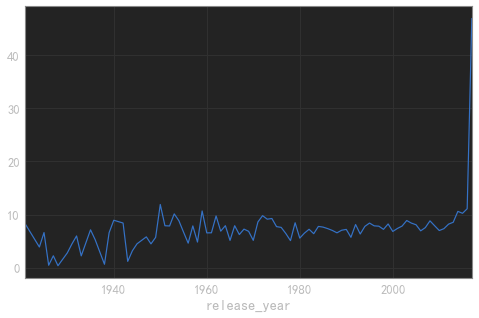

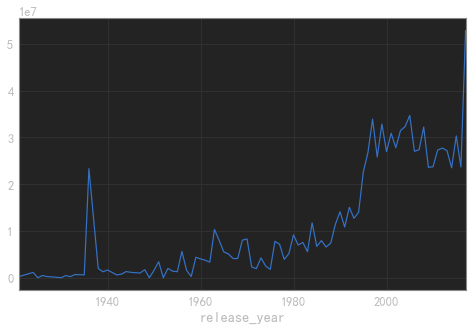

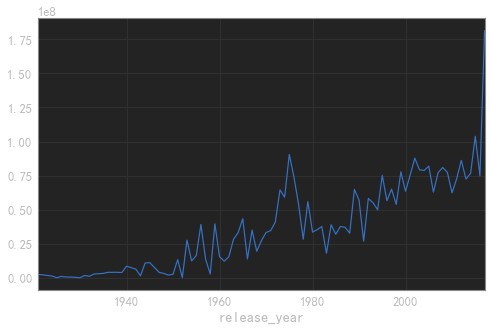

In [8]:
# 训练集中不同年份电影受欢迎程度
plt.figure(figsize=(8,5))
release_year_mean_data['popularity'].plot()

# 训练集中不同年份电影投资程度
plt.figure(figsize=(8,5))
release_year_mean_data['budget'].plot()

# 训练集中不同年份电影票房程度
plt.figure(figsize=(8,5))
release_year_mean_data['revenue'].plot()

Text(0.5, 0, 'Budget of the Movie')

Text(0.5, 0, 'Revenue of the Movie')

Text(0.5, 0, 'Popularity of the Movie')

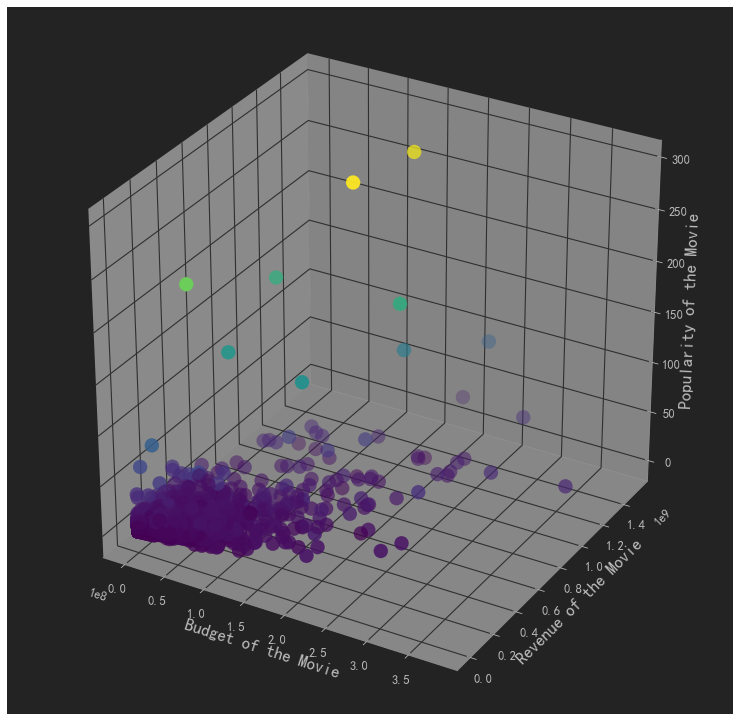

In [9]:
# 3D图分析'budget','popularity','revenue'之间的关系
fig = plt.figure(figsize=(13,13))
ax = plt.subplot(111,projection='3d')
zdata =train.popularity
xdata =train.budget
ydata = train.revenue
ax.scatter3D(xdata, ydata, zdata, c=zdata, s = 200)
ax.set_xlabel('Budget of the Movie',fontsize=17)
ax.set_ylabel('Revenue of the Movie',fontsize=17)
ax.set_zlabel('Popularity of the Movie',fontsize=17)

<Figure size 936x936 with 0 Axes>

Text(0.5, 1.0, '皮尔逊相关系数')

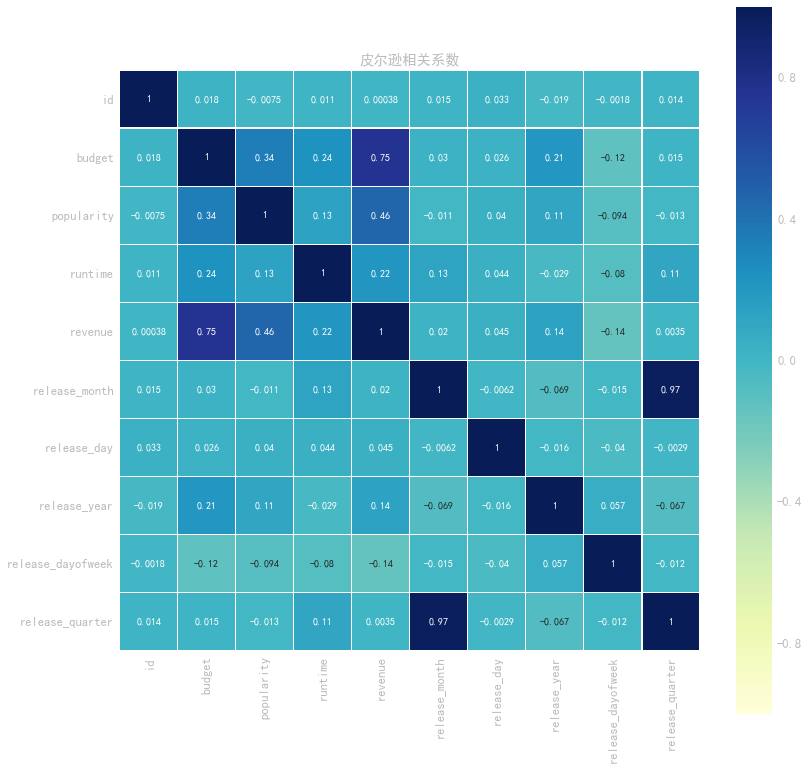

In [10]:
# Creating correlation matrix 
corr = train.corr()
plt.figure(figsize=(13,13))
plt.title("皮尔逊相关系数")
sns.heatmap(corr,linewidths=0.1,square=True,linecolor="white",annot=True,cmap='YlGnBu',vmin=-1,vmax=1)

In [11]:
# 将json字符串转化成字典
json_cols = ['belongs_to_collection','genres','production_companies',
             'production_countries','spoken_languages','Keywords','cast','crew']

def json_to_dict(df):
    for col in json_cols:
        df[col] = df[col].map(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    return df

train = json_to_dict(train)
test = json_to_dict(test)

# belongs_to_collection

In [12]:
# 新建collection_name，并将其进行标签化转换
train['collection_name'] = train['belongs_to_collection'].map(lambda x:[{} if n == {} else n['name'] for n in x]).map(lambda x: ",".join(x) if x != [] else 0)
test['collection_name'] = test['belongs_to_collection'].map(lambda x:[{} if n == {} else n['name'] for n in x]).map(lambda x: ",".join(x) if x != [] else 0)
# 新建has_collection
train['has_collection']  = train['belongs_to_collection'].map(lambda x: 1 if x != {} else 0)
test['has_collection']  = test['belongs_to_collection'].map(lambda x: 1 if x != {} else 0)                                                                                                                    

train = train.drop(['belongs_to_collection'],axis=1)
test = test.drop(['belongs_to_collection'],axis=1)

# genres

,num_genres,revenue
4,4,1.062124e+08
6,6,9.233659e+07
3,3,8.890519e+07
5,5,8.258928e+07
7,7,4.736216e+07
2,2,4.486235e+07
1,1,3.971904e+07
0,0,1.110844e+06


<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'movie title wordcloud')

<Figure size 720x7200 with 0 Axes>

Text(0.5, 1.0, 'Drama revenue with release_year')

Text(0.5, 1.0, 'Comedy revenue with release_year')

Text(0.5, 1.0, 'Thriller revenue with release_year')

Text(0.5, 1.0, 'Action revenue with release_year')

Text(0.5, 1.0, 'Romance revenue with release_year')

Text(0.5, 1.0, 'Crime revenue with release_year')

Text(0.5, 1.0, 'Adventure revenue with release_year')

Text(0.5, 1.0, 'Horror revenue with release_year')

Text(0.5, 1.0, 'Science Fiction revenue with release_year')

Text(0.5, 1.0, 'Family revenue with release_year')

Text(0.5, 1.0, 'Fantasy revenue with release_year')

Text(0.5, 1.0, 'Mystery revenue with release_year')

Text(0.5, 1.0, 'Animation revenue with release_year')

Text(0.5, 1.0, 'History revenue with release_year')

Text(0.5, 1.0, 'Music revenue with release_year')

Text(0.5, 1.0, 'War revenue with release_year')

Text(0.5, 1.0, 'Documentary revenue with release_year')

Text(0.5, 1.0, 'Western revenue with release_year')

Text(0.5, 1.0, 'Foreign revenue with release_year')

Text(0.5, 1.0, 'TV Movie revenue with release_year')

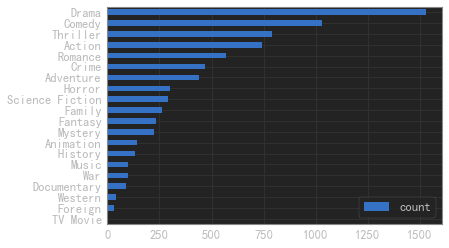

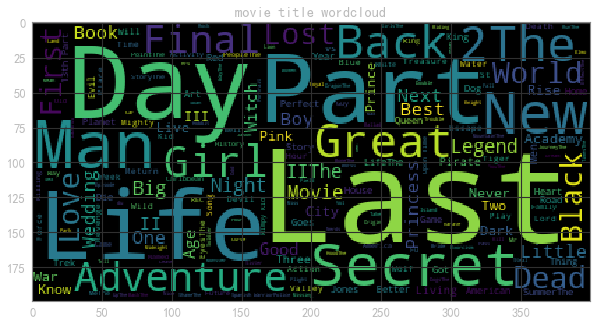

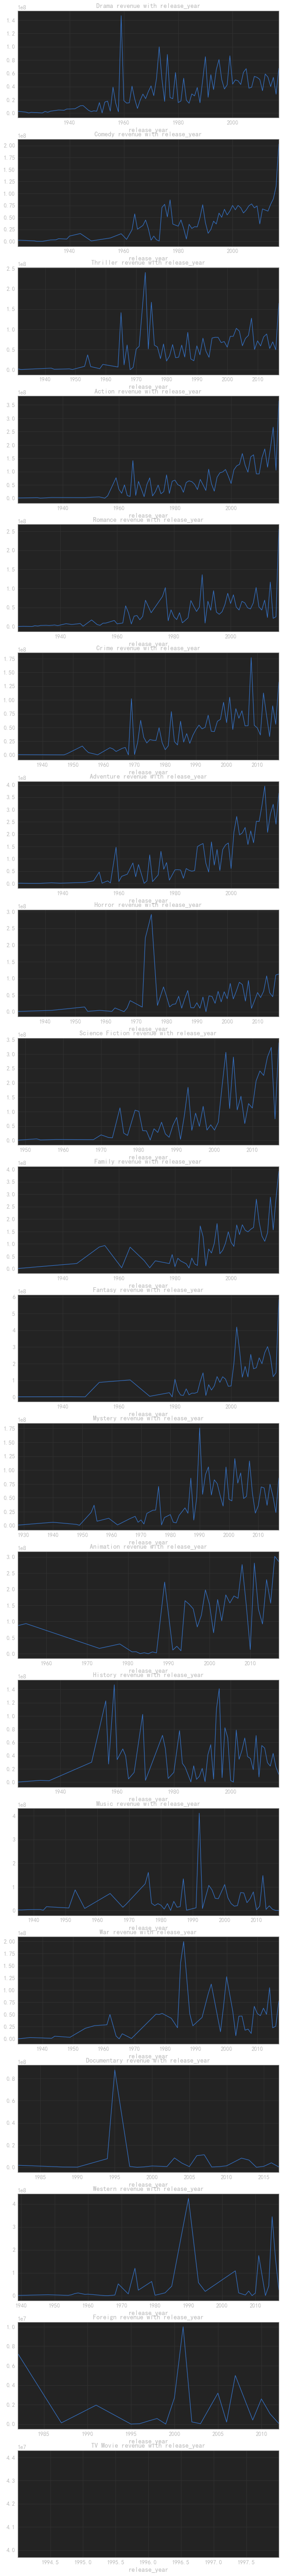

In [13]:
# genres，电影类型
# 根据类型对电影片名进行文本分析，并根据类型对历年的收益进行比较。
list_genres = list(train['genres'].map(lambda x: [n['name'] if x != {} else [] for n in x]).values) # x是字典列表，n是列表中的字典元素
most_common_genres = Counter([j for i in list_genres for j in i]).most_common()

# 绘制genres数量柱状图
dict_genres = dict(most_common_genres) # 传入可迭代对象构造字典
df_genres = pd.DataFrame(dict_genres,index=['count']).T
df_genres.sort_values('count',ascending=True).plot(kind='barh')

# 考虑同一电影如果类型多，对票房是否有影响(结论是无影响)
train['num_genres'] = train['genres'].map(lambda x:len(x) if x != {} else 0)
test['num_genres'] = test['genres'].map(lambda x:len(x) if x != {} else 0)
train.groupby('num_genres',as_index=False)['revenue'].mean().sort_values('revenue',ascending=False) 
# 转换genres特征，值为同一电影的所有标签
train['genres'] = train['genres'].map(lambda x:[i['name'] if i != {} else [] for i in x]).map(lambda x: ','.join(x))
test['genres'] = test['genres'].map(lambda x:[i['name'] if i != {} else [] for i in x]).map(lambda x: ','.join(x))

# 对genres进行独热编码，转成稀疏矩阵,如genres_Comedy,genres_Drama...
for i in df_genres.index.to_list():
    train['genres_'+i] = train['genres'].map(lambda x: 1 if i in x else 0)
    test['genres_'+i] = test['genres'].map(lambda x: 1 if i in x else 0)


# 电影片名文本分析,使用wordcloud
text = "".join(n for n in train['title'])
plt.figure(figsize=(10,10))
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud)
plt.title("movie title wordcloud")

# 分析不同类型电影随着年份，票房的增长趋势
revenue_genres = {}
for i in df_genres.index.to_list():
     revenue_genres[i] = train.loc[train['genres_'+i] == 1,].groupby('release_year')['revenue'].mean() # dataframe列表，存放按年排列的平均票房收入

plt.figure(figsize=(10,100))
for i,j in enumerate(df_genres.index.to_list()):
    plt.subplot(len(df_genres.index.to_list()),1,i+1)
    plt.title(j+" revenue with release_year")
    revenue_genres[j].plot()

train = train.drop(['genres'],axis=1)
test = test.drop(['genres'],axis=1)

# production_companies

,num_production_companies,revenue
10,10,2.801926e+08
11,11,1.293359e+08
7,7,1.195743e+08
5,5,1.014942e+08
6,6,9.581082e+07
4,4,9.238211e+07
9,9,8.769570e+07
8,8,8.307271e+07
12,12,7.622988e+07
3,3,7.461310e+07


<Figure size 720x3600 with 0 Axes>

Text(0.5, 1.0, 'Warner_Bros revenue over release_year')

Text(0.5, 1.0, 'Universal_Pictures revenue over release_year')

Text(0.5, 1.0, 'Twentieth_Century_Fox_Film revenue over release_year')

Text(0.5, 1.0, 'Columbia_Pictures revenue over release_year')

Text(0.5, 1.0, 'MGM revenue over release_year')

Text(0.5, 1.0, 'New_Line_Cinema revenue over release_year')

Text(0.5, 1.0, 'Touchstone_Pictures revenue over release_year')

Text(0.5, 1.0, 'Walt_Disney revenue over release_year')

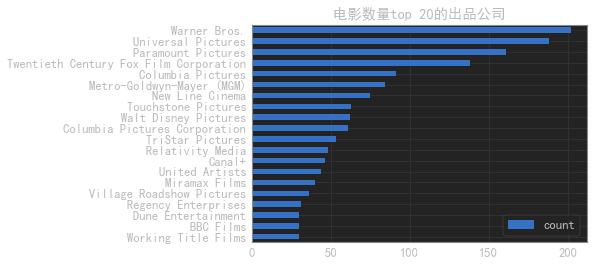

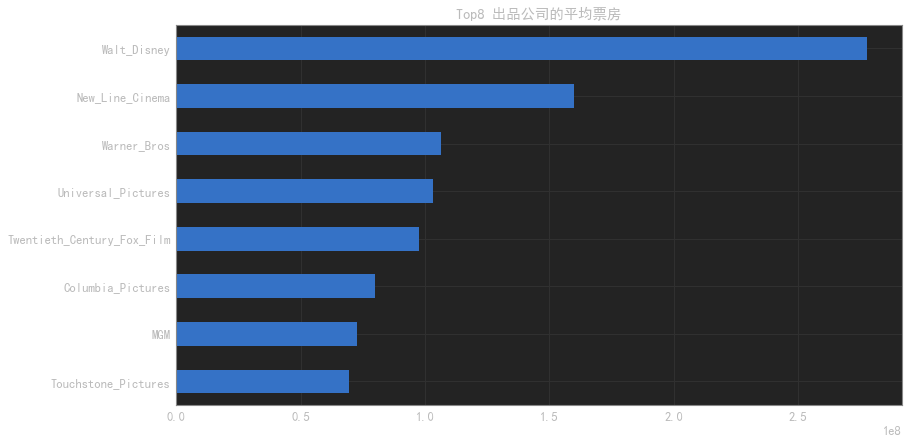

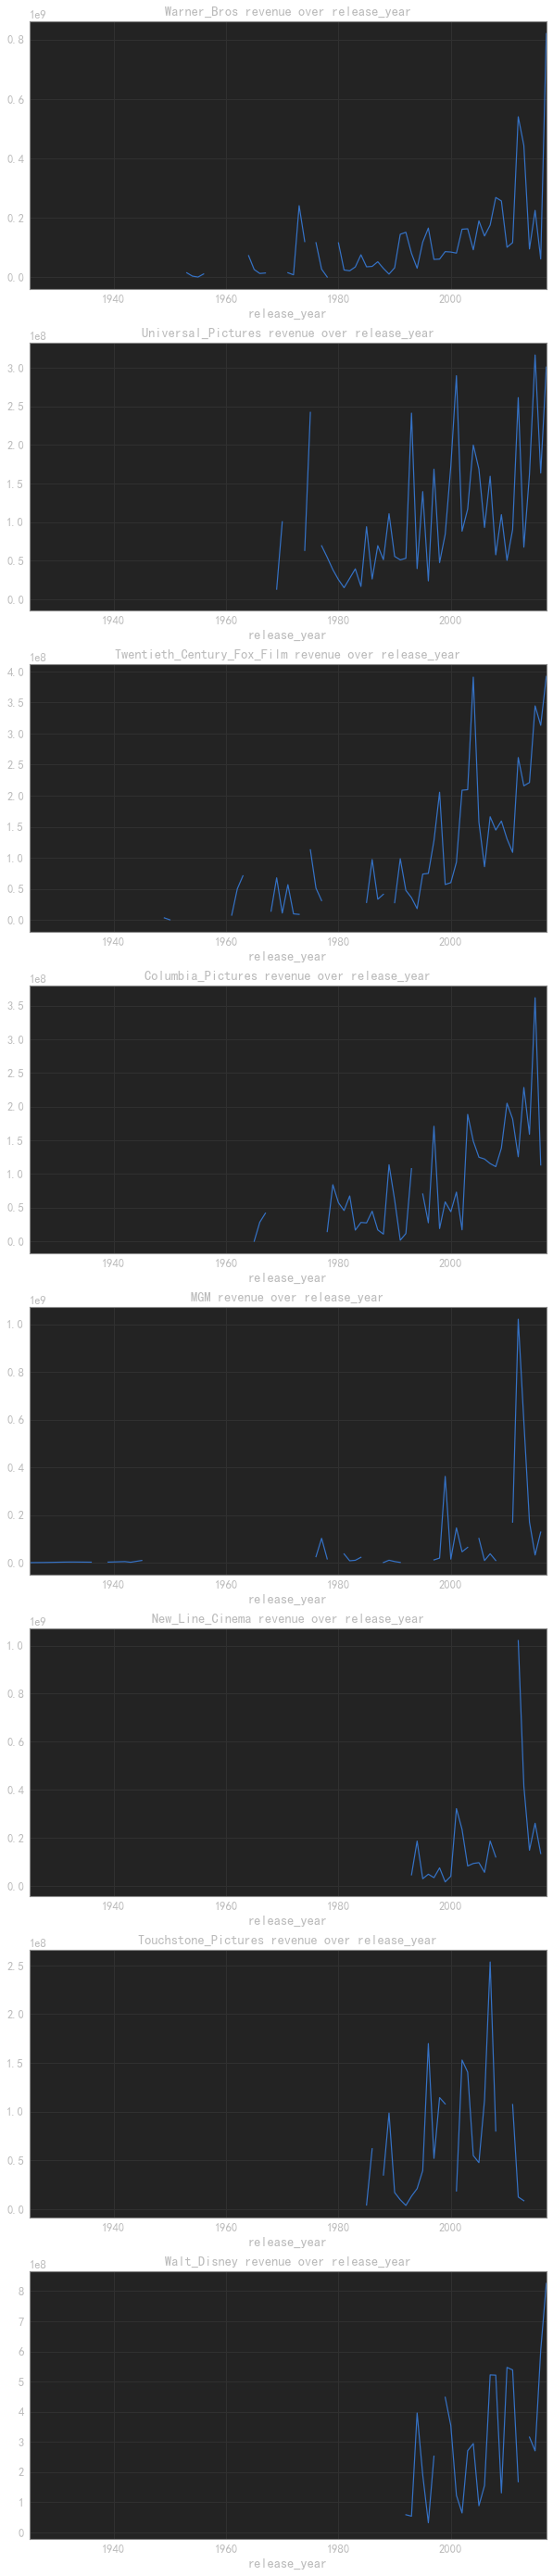

In [14]:
# production_companies,分析哪个制片公司出品的电影最多
list_production_companies = train['production_companies'].map(lambda x:[i['name'] for i in x])
most_common_production_companies = Counter([j for i in list_production_companies for j in i]).most_common()
top20_production_companies = [m[0] for m in most_common_production_companies[:20]]

# 绘制production_companies top20 数量柱状图
dict_production_companies = dict(most_common_production_companies) # 传入可迭代对象构造字典
df_production_companies = pd.DataFrame(dict_production_companies,index=['count']).T
df_production_companies.head(20).sort_values('count',ascending=True).plot(kind='barh',title="电影数量top 20的出品公司")

# 考虑同一电影如果类型多，对票房是否有影响(结论是无影响)
train['num_production_companies']  = train['production_companies'].map(lambda x: len(x) if x!= {} else 0)
test['num_production_companies']  = test['production_companies'].map(lambda x: len(x) if x!= {} else 0)
train.groupby('num_production_companies',as_index=False)['revenue'].mean().sort_values('revenue',ascending=False)

# 转换production_companies特征，值为同一电影内的所有标签
train['production_companies'] = train['production_companies'].map(lambda x: [i['name'] if i!={} else [] for i in x]).map(lambda x: ','.join(x))
test['production_companies'] = test['production_companies'].map(lambda x: [i['name'] if i!={} else [] for i in x]).map(lambda x: ','.join(x))

# 将top20出品公司进行独热编码
for i in top20_production_companies:
    train['companies_' + i] = train['production_companies'].map(lambda x: 1 if i in x else 0)
    test['companies_' + i] = test['production_companies'].map(lambda x: 1 if i in x else 0)

# 筛选top8电影的数据
Warner_Bros = train.loc[train['companies_Warner Bros.'] == 1,]
Universal_Pictures = train.loc[train['companies_Universal Pictures'] == 1,]
Twentieth_Century_Fox_Film = train.loc[train['companies_Twentieth Century Fox Film Corporation'] == 1,]
Columbia_Pictures = train.loc[train['companies_Columbia Pictures'] == 1,]
MGM = train.loc[train['companies_Metro-Goldwyn-Mayer (MGM)'] == 1,]
New_Line_Cinema = train.loc[train['companies_New Line Cinema'] == 1,]
Touchstone_Pictures = train.loc[train['companies_Touchstone Pictures'] == 1,]
Walt_Disney_Pictures = train.loc[train['companies_Walt Disney Pictures'] == 1,]

# top8电影，不同年份的平均票房
Warner_Bros_revenue = Warner_Bros.groupby('release_year')['revenue'].mean()
Universal_Pictures_revenue = Universal_Pictures.groupby('release_year')['revenue'].mean()
Twentieth_Century_Fox_Film_revenue = Twentieth_Century_Fox_Film.groupby('release_year')['revenue'].mean()
Columbia_Pictures_revenue = Columbia_Pictures.groupby('release_year')['revenue'].mean()
MGM_revenue = MGM.groupby('release_year')['revenue'].mean()
New_Line_Cinema_revenue = New_Line_Cinema.groupby('release_year')['revenue'].mean()
Touchstone_Pictures_revenue = Touchstone_Pictures.groupby('release_year')['revenue'].mean()
Walt_Disney_Pictures_revenue = Walt_Disney_Pictures.groupby('release_year')['revenue'].mean()

# 合并top8电影不同年份的平均票房数据
companies_revenue_concat = pd.concat([Warner_Bros_revenue,Universal_Pictures_revenue,Twentieth_Century_Fox_Film_revenue,
                                     Columbia_Pictures_revenue,MGM_revenue,New_Line_Cinema_revenue,Touchstone_Pictures_revenue,
                                     Walt_Disney_Pictures_revenue],axis=1)

companies_revenue_concat.columns = ['Warner_Bros','Universal_Pictures','Twentieth_Century_Fox_Film',
                                    'Columbia_Pictures','MGM','New_Line_Cinema','Touchstone_Pictures','Walt_Disney']

# 分析top10出品公司，平均票房排名
fig = plt.figure(figsize=(13, 7))
companies_revenue_concat.mean().sort_values(ascending=True).plot(kind='barh',title="Top8 出品公司的平均票房")

# 分析top8出品公司，平均票房增长趋势
plt.figure(figsize=(10,50))
for i,j in enumerate(companies_revenue_concat.columns.to_list()):
    plt.subplot(len(companies_revenue_concat.columns.to_list()),1,i+1)
    plt.title(j+" revenue over release_year")
    companies_revenue_concat[j].plot()
    
train = train.drop(['production_companies'],axis=1)
test = test.drop(['production_companies'],axis=1)

# production_countries

,num_production_countries,revenue
4,4,8.681251e+07
2,2,8.619546e+07
3,3,7.077955e+07
5,5,6.369905e+07
1,1,6.308391e+07
7,8,1.675637e+07
0,0,4.090428e+06
6,6,2.957964e+06


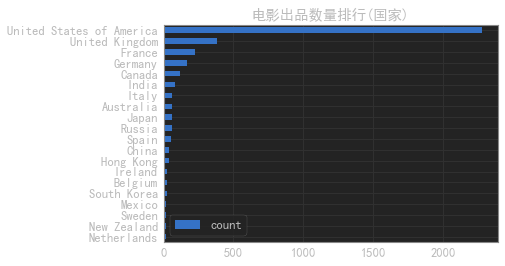

In [15]:
# production_countries,分析不同的出品国家出品的电影数量排行
list_production_countries = train['production_countries'].map(lambda x: [i['name'] for i in x])
most_common_production_countries = Counter([j for i in list_production_countries for j in i]).most_common()
top20_production_countries = [m[0] for m in most_common_production_countries[:20]]

# 绘制排名直方图
dict_production_countries = dict(most_common_production_countries)
df_production_countries = pd.DataFrame(dict_production_countries,index=['count']).T
df_production_countries.head(20).sort_values('count',ascending=True).plot(kind='barh',title="电影出品数量排行(国家)")

# 考虑同一电影如果类型多，对票房是否有影响(结论是无影响)
train['num_production_countries']  = train['production_countries'].map(lambda x: len(x) if x!= {} else 0)
test['num_production_countries']  = test['production_countries'].map(lambda x: len(x) if x!= {} else 0)
train.groupby('num_production_countries',as_index=False)['revenue'].mean().sort_values('revenue',ascending=False)

# 转换production_countries特征，值为同一电影内的所有标签
train['production_countries'] = train['production_countries'].map(lambda x: [i['name'] if i!={} else [] for i in x]).map(lambda x: ','.join(x))
test['production_countries'] = test['production_countries'].map(lambda x: [i['name'] if i!={} else [] for i in x]).map(lambda x: ','.join(x))

# 将top20出品国家进行独热编码
for i in top20_production_countries:
    train['countries_' + i] = train['production_countries'].map(lambda x:1 if i in x else 0)
    test['countries_' + i] = test['production_countries'].map(lambda x:1 if i in x else 0)
    
train = train.drop(['production_countries'],axis=1)
test = test.drop(['production_countries'],axis=1)

# spoken_languages

<Figure size 936x504 with 0 Axes>

,num_spoken_languages,revenue
5,5,1.957296e+08
6,6,1.429899e+08
7,7,1.262766e+08
4,4,7.834544e+07
3,3,7.372076e+07
2,2,7.070776e+07
1,1,6.342463e+07
9,9,1.462483e+07
0,0,7.348543e+06
8,8,5.724615e+05


<Figure size 936x504 with 0 Axes>

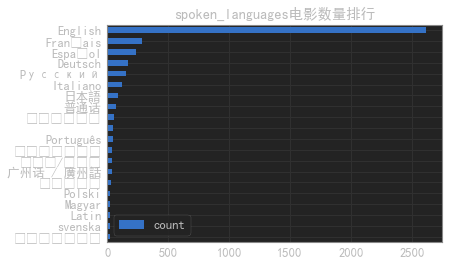

In [16]:
# spoken_languages，分析不同语言的电影数量排行
list_spoken_languages = train['spoken_languages'].map(lambda x: [i['name'] if i!= [] else [] for i in x])
most_common_spoken_languages = Counter([j for i in list_spoken_languages for j in i]).most_common()
top20_spoken_languages = [i[0] for i in most_common_spoken_languages[:20]]

# 绘画spoken_languages柱状图
dict_spoken_languages = dict(most_common_spoken_languages)
df_spoken_languages = pd.DataFrame(dict_spoken_languages,index=['count']).T

plt.figure(figsize=(13,7))
df_spoken_languages.head(20).sort_values('count',ascending=True).plot(kind='barh',title="spoken_languages电影数量排行")

# 考虑同一电影如果类型多，对票房是否有影响(结论是无影响)
train['num_spoken_languages']  = train['spoken_languages'].map(lambda x: len(x) if x!= {} else 0)
test['num_spoken_languages']  = test['spoken_languages'].map(lambda x: len(x) if x!= {} else 0)
train.groupby('num_spoken_languages',as_index=False)['revenue'].mean().sort_values('revenue',ascending=False)

# 转换spoken_languages特征，值为同一电影内的所有标签
train['spoken_languages'] = train['spoken_languages'].map(lambda x: [i['name'] if i!={} else [] for i in x]).map(lambda x: ','.join(x))
test['spoken_languages'] = test['spoken_languages'].map(lambda x: [i['name'] if i!={} else [] for i in x]).map(lambda x: ','.join(x))

# 将top20出品国家进行独热编码
for i in top20_spoken_languages:
    train['languages_' + i] = train['spoken_languages'].map(lambda x:1 if i in x else 0)
    test['languages_' + i] = test['spoken_languages'].map(lambda x:1 if i in x else 0)
    
train = train.drop(['spoken_languages'],axis=1)
test = test.drop(['spoken_languages'],axis=1)

# Keywords

<Figure size 936x504 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

,num_Keywords,revenue
33,33,3.529272e+08
20,20,2.095922e+08
27,27,1.580198e+08
16,16,1.556211e+08
21,21,1.442554e+08
19,19,1.214543e+08
18,18,1.164181e+08
9,9,1.124069e+08
14,14,1.116179e+08
32,32,1.079897e+08


<Figure size 936x504 with 0 Axes>

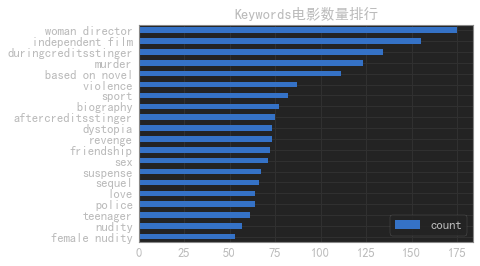

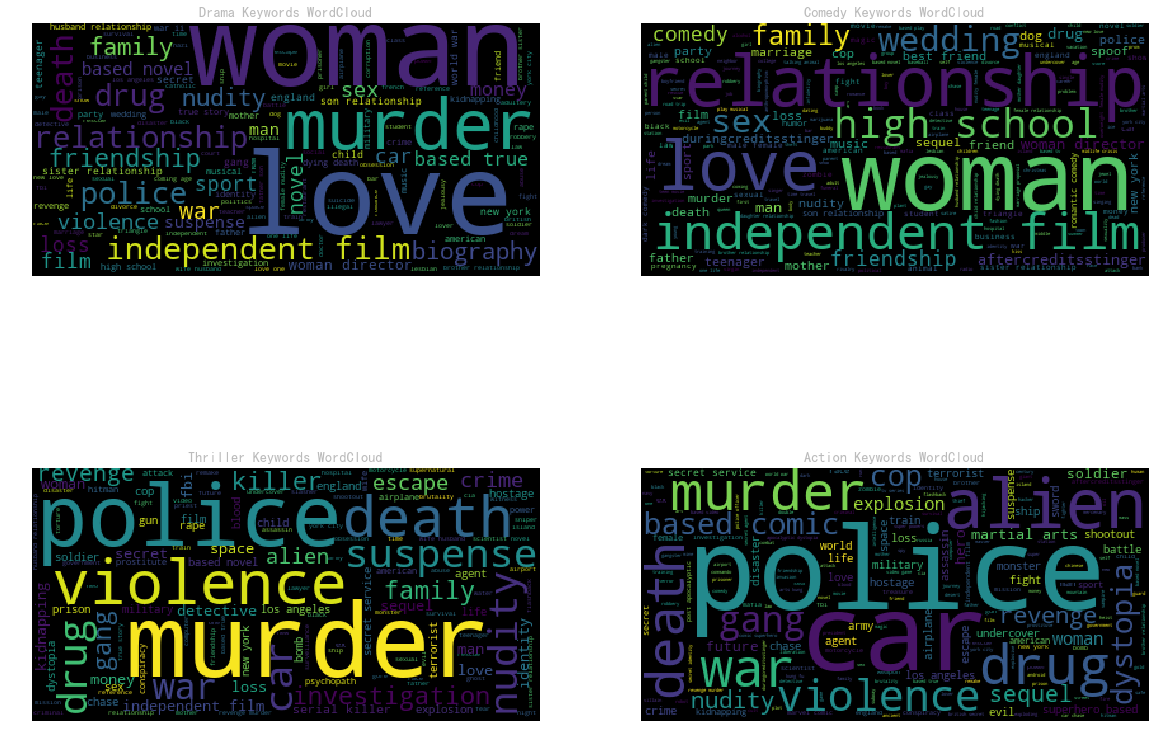

In [17]:
list_Keywords = train['Keywords'].map(lambda x:[i['name'] if i!= [] else [] for i in x])
most_common_Keywords = Counter([j for i in list_Keywords for j in i]).most_common()
top20_Keywords = [i[0] for i in most_common_Keywords[:20]]

# 绘画柱状图
dict_Keywords = dict(most_common_Keywords)
df_Keywords = pd.DataFrame(dict_Keywords,index=['count']).T

plt.figure(figsize=(13,7))
df_Keywords.head(20).sort_values('count',ascending=True).plot(kind='barh',title='Keywords电影数量排行')

# keywords云图
def KeywordsWC(i,genresType):
    text = ''.join([i for i in train.loc[train['genres_'+genresType]==1,'Keywords'].
                    map(lambda x:[i['name'] for i in x]).map(lambda x:' '.join(x))])
    wordcloud = WordCloud().generate(text)
    plt.subplot(2,2,i+1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(genresType+" Keywords WordCloud")

plt.figure(figsize=(20,15))
for i,j in enumerate(df_genres.head(4).index.tolist()):
    KeywordsWC(i,j)

# 考虑同一电影如果类型多，对票房是否有影响(结论是无影响)
train['num_Keywords']  = train['Keywords'].map(lambda x: len(x) if x!= {} else 0)
test['num_Keywords']  = test['Keywords'].map(lambda x: len(x) if x!= {} else 0)
train.groupby('num_Keywords',as_index=False)['revenue'].mean().sort_values('revenue',ascending=False)

# 转换Keywords特征，值为同一电影内的所有标签
train['Keywords'] = train['Keywords'].map(lambda x: [i['name'] if i!={} else [] for i in x]).map(lambda x: ','.join(x))
test['Keywords'] = test['Keywords'].map(lambda x: [i['name'] if i!={} else [] for i in x]).map(lambda x: ','.join(x))

# 将top20 keywords进行独热编码
for i in top20_Keywords:
    train['Keywords_'+i] = train['Keywords'].map(lambda x:1 if i in x else 0)
    test['Keywords_'+i] = test['Keywords'].map(lambda x:1 if i in x else 0)
    
train = train.drop(['Keywords'],axis=1)
test = test.drop(['Keywords'],axis=1)

# cast

<Figure size 936x504 with 0 Axes>

<Figure size 936x504 with 0 Axes>

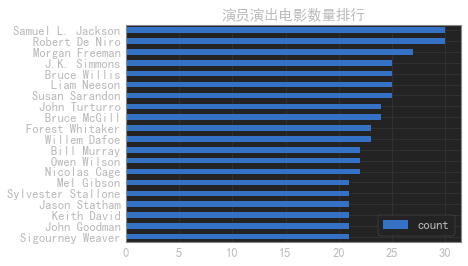

In [18]:
# 男女演员名字分析
list_cast = train['cast'].map(lambda x:[i['name'] if i!= [] else [] for i in x])
most_common_cast = Counter([j for i in list_cast for j in i]).most_common()
top20_cast = [i[0] for i in most_common_cast[:20]]

# 绘画柱状图
dict_cast = dict(most_common_cast)
df_cast = pd.DataFrame(dict_cast,index=['count']).T

plt.figure(figsize=(13,7))
df_cast.head(20).sort_values('count',ascending=True).plot(kind='barh',title='演员演出电影数量排行')

train['num_cast']  = train['cast'].map(lambda x: len(x) if x!= {} else 0)
test['num_cast']  = test['cast'].map(lambda x: len(x) if x!= {} else 0)

# 转换Keywords特征，值为同一电影内的所有标签
train['cast'] = train['cast'].map(lambda x: [i['name'] if i!={} else [] for i in x]).map(lambda x: ','.join(x))
test['cast'] = test['cast'].map(lambda x: [i['name'] if i!={} else [] for i in x]).map(lambda x: ','.join(x))

# 将top20 keywords进行独热编码
for i in top20_cast:
    train['cast_'+i] = train['cast'].map(lambda x:1 if i in x else 0)
    test['cast_'+i] = test['cast'].map(lambda x:1 if i in x else 0)
    
train = train.drop(['cast'],axis=1)
test = test.drop(['cast'],axis=1)

# crew

<Figure size 936x504 with 0 Axes>

<Figure size 936x504 with 0 Axes>

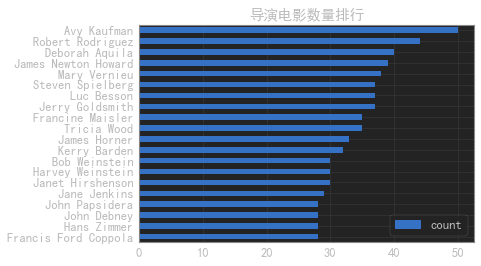

In [19]:
list_crew = train['crew'].map(lambda x:[i['name'] if i!= [] else [] for i in x])
most_common_crew = Counter([j for i in list_crew for j in i]).most_common()
top20_crew = [i[0] for i in most_common_crew[:20]]

# 绘画柱状图
dict_crew = dict(most_common_crew)
df_crew = pd.DataFrame(dict_crew,index=['count']).T

plt.figure(figsize=(13,7))
df_crew.head(20).sort_values('count',ascending=True).plot(kind='barh',title='导演电影数量排行')

train['num_crew']  = train['crew'].map(lambda x: len(x) if x!= {} else 0)
test['num_crew']  = test['crew'].map(lambda x: len(x) if x!= {} else 0)

# 转换Keywords特征，值为同一电影内的所有标签
train['crew'] = train['crew'].map(lambda x: [i['name'] if i!={} else [] for i in x]).map(lambda x: ','.join(x))
test['crew'] = test['crew'].map(lambda x: [i['name'] if i!={} else [] for i in x]).map(lambda x: ','.join(x))

# 将top20 keywords进行独热编码
for i in top20_cast:
    train['crew_'+i] = train['crew'].map(lambda x:1 if i in x else 0)
    test['crew_'+i] = test['crew'].map(lambda x:1 if i in x else 0)
    
train = train.drop(['crew'],axis=1)
test = test.drop(['crew'],axis=1)

<Figure size 1080x720 with 0 Axes>

revenue的偏态系数为：4.543306693202327
train数据集中budget的偏态系数为：3.09
train数据集中popularity的偏态系数为：14.37
test数据集中budget的偏态系数为：2.75
test数据集中popularity的偏态系数为：23.68


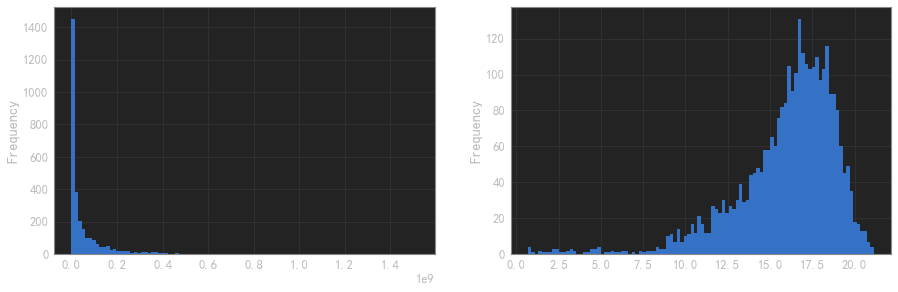

In [20]:
# revenue特征转换前后对比
plt.figure(figsize=(15,10))
plt.subplot(221)
train['revenue'].plot(kind='hist',bins=100)
plt.subplot(222)
np.log1p(train['revenue']).plot(kind='hist',bins=100)
print('revenue的偏态系数为：{}'.format(skew(train['revenue'])))

# budget和popularity偏态系数
print('train数据集中budget的偏态系数为：{:.2f}'.format(skew(train['budget'])))
print('train数据集中popularity的偏态系数为：{:.2f}'.format(skew(train['popularity'])))
print('test数据集中budget的偏态系数为：{:.2f}'.format(skew(test['budget'])))
print('test数据集中popularity的偏态系数为：{:.2f}'.format(skew(test['popularity'])))

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'budget分布')

Text(0.5, 1.0, 'log budget分布')

Text(0.5, 1.0, 'popularity分布')

Text(0.5, 1.0, 'log popularity分布')

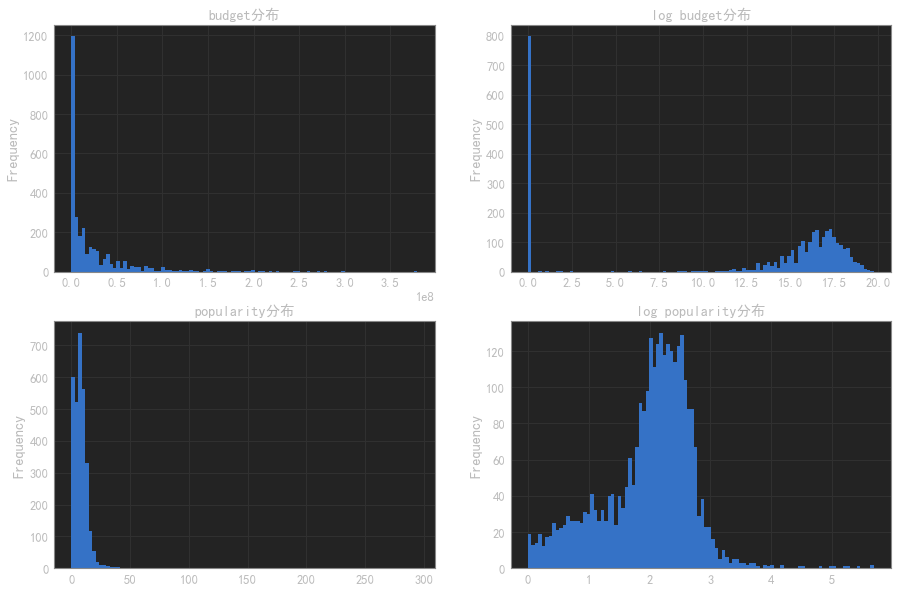

In [21]:
# budget和popularity特征转换前后对比
plt.figure(figsize=(15,10))
plt.subplot(221)
train['budget'].plot(kind='hist',bins=100)
plt.title('budget分布')
plt.subplot(222)
np.log1p(train['budget']).plot(kind='hist',bins=100)
plt.title('log budget分布')
plt.subplot(223)
train['popularity'].plot(kind='hist',bins=100)
plt.title('popularity分布')
plt.subplot(224)
np.log1p(train['popularity']).plot(kind='hist',bins=100)
plt.title('log popularity分布')

In [22]:
# 新增log_budget和log_popularity特征
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])
train['log_popularity'] = np.log1p(train['popularity'])
test['log_popularity'] = np.log1p(test['popularity'])

In [23]:
def prepare(df):
    df['_budget_runtime_ratio'] = df['budget']/df['runtime']
    df['_budget_popularity_ratio'] = df['budget']/df['popularity']
    df['_budget_year_ratio'] = df['budget']/(df['release_year']*df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']
    df['_year_to_log_budget'] = df['release_year'] / df['log_budget']
    df['_year_to_log_popularity'] = df['release_year'] / df['log_popularity']
    
    df['has_homepage'] = df['homepage'].map(lambda x:0 if pd.isnull(x) else 1)
    df['has_tagline'] = df['tagline'].map(lambda x:0 if pd.isnull(x) else 1)
    df['isTitleDifferent'] = 1
    df.loc[ df['original_title'] == df['title'] ,"isTitleDifferent"] = 0 
    df['isMovieReleased'] = 1
    df.loc[ df['status'] != "Released" ,"isMovieReleased"] = 0 
    
    df['original_title_letter_count'] = df['original_title'].str.len() 
    df['original_title_word_count'] = df['original_title'].str.split().str.len() 
    df['title_word_count'] = df['title'].str.split().str.len()
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()
    df['meanruntimeByYear'] = df.groupby("release_year")["runtime"].aggregate('mean')
    df['meanPopularityByYear'] = df.groupby("release_year")["popularity"].aggregate('mean')
    df['meanBudgetByYear'] = df.groupby("release_year")["budget"].aggregate('mean')

    return df


train_new = prepare(train)
test_new = prepare(test)

# model

In [ ]:
# train_new = pd.read_csv("../data/train_new.csv")
# test_new = pd.read_csv("../data/test_new.csv")
drop_columns=['homepage','imdb_id','poster_path','status','title', 'release_date','tagline',
              'overview', 'original_title','original_language','collection_name']
train_new=train_new.drop(drop_columns,axis=1)
test_new=test_new.drop(drop_columns,axis=1)

# 构建模型要输入的数据
X_train = train_new.drop(['id','revenue'],axis=1)
y_train = np.log1p(train_new['revenue'])
X_test = test_new.drop(['id'],axis=1)

print( "updated train dataset:", train_new.shape,"\n","updated test dataset: ",test_new.shape)
# Just double checking the difference of variables between train and test 
print(train_new.columns.difference(test_new.columns)) # good to go!

## catboots

In [95]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor

def stacking_cat(train_x,train_y,test_x):
    folds = 5
    seed = 2019
    test_pre_mean = np.zeros((test_x.shape[0],1)) # 每次的fold预测值求和，再求均值，得到最终预测值
    test_pre = np.zeros((folds,test_x.shape[0],1)) # 有多少个folds，就有多少份数据
    cv_scores = [] # RSME的平均分
    
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    for kfold_,(train_index,valid_index) in enumerate(kf.split(train_x,train_y)):
        print('*****************staring cat fitting*************')
        print("===================Kfold :{0}====================".format(kfold_))
        tr_x = train_x.values[train_index]
        tr_y = train_y.iloc[train_index]
        val_x = train_x.values[valid_index]
        val_y = train_y.iloc[valid_index]
        
        model = CatBoostRegressor(iterations=17000, 
                                   depth = 8,
    #                                learning_rate = 0.02,
                               loss_function='RMSE',
                               eval_metric='RMSE',
                               bagging_temperature=0.8,
                               od_type='Iter',
                               rsm = 0.7,
                               od_wait=2,
                               metric_period = 50,
    #                                l2_leaf_reg = 20,
                               thread_count = 10,
                               random_seed = seed
                              )
        model.fit(tr_x, tr_y, eval_set=(val_x, val_y),use_best_model=True)
        val_pre= model.predict(val_x)
        test_pre[kfold_,:] = model.predict(test_x).reshape(test_x.shape[0],1)
        cv_scores.append(mean_squared_error(val_y,val_pre) ** 0.5)
#         print("Catboots now score is: {0}".format(cv_scores))
    test_pre_mean[:] = test_pre.mean(axis = 0)
    print("Catboots mean score is: {0}".format(np.mean(cv_scores)))
    scores['cat'] = np.mean(cv_scores)
    
    return test_pre_mean

## lgb

In [94]:
import lightgbm as lgb
def stacking_lgb(train_x,train_y,test_x):
    folds = 5
    seed = 2019
    test_pre_mean = np.zeros((test_x.shape[0],1)) # 每次的fold预测值求和，再求均值，得到最终预测值
    test_pre = np.zeros((folds,test_x.shape[0],1)) # 有多少个folds，就有多少份数据
    cv_scores = [] # RSME的平均分
    
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    for kfold_,(train_index,valid_index) in enumerate(kf.split(train_x,train_y)):
        print('*****************staring lgb fitting*************')
        print("===================Kfold :{0}====================".format(kfold_))
        tr_x = train_x.values[train_index]
        tr_y = train_y.iloc[train_index]
        val_x = train_x.values[valid_index]
        val_y = train_y.iloc[valid_index]
        
        model = lgb.LGBMRegressor(n_estimators=10000, 
                             objective='regression', 
                             metric='rmse',
                             eval_metric='rmse',
                             max_depth = 5,
                             num_leaves=5, 
                             min_child_samples=100,
                             learning_rate=0.001,
                             boosting = 'gbdt',
                             min_data_in_leaf= 10,
                             feature_fraction = 0.2,
                             bagging_freq = 1,
                             bagging_fraction = 0.9,
                             importance_type='gain',
                             lambda_l1 = 0.2,
                             bagging_seed=seed, 
                             subsample=.8, 
                             colsample_bytree=.9,
                             use_best_model=True)

        model.fit(tr_x, tr_y, eval_set=(val_x, val_y),verbose=False)
        val_pre= model.predict(val_x)
        test_pre[kfold_,:] = model.predict(test_x).reshape(test_x.shape[0],1)
        cv_scores.append(mean_squared_error(val_y,val_pre) ** 0.5)
#         print("lgb now score is: {0}".format(cv_scores))
    test_pre_mean[:] = test_pre.mean(axis = 0)
    print("lgb mean score is: {0}".format(np.mean(cv_scores)))
    scores['lgb'] = np.mean(cv_scores)
    
    return test_pre_mean

## xgboost

In [97]:
import xgboost as xgb
def stacking_xgb(train_x,train_y,test_x):
    folds = 5
    seed = 2019
    test_pre_mean = np.zeros((test_x.shape[0],1)) # 每次的fold预测值求和，再求均值，得到最终预测值
    test_pre = np.zeros((folds,test_x.shape[0],1)) # 有多少个folds，就有多少份数据
    cv_scores = [] # RSME的平均分
    
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    for kfold_,(train_index,valid_index) in enumerate(kf.split(train_x,train_y)):
        print('*****************staring xgb fitting*************')
        print("===================Kfold :{0}====================".format(kfold_))
        tr_x = train_x.iloc[train_index]
        tr_y = train_y[train_index]
        val_x = train_x.iloc[valid_index]
        val_y = train_y[valid_index]
        
        model = xgb.XGBRegressor(eta=0.01,
                                 max_depth=6,
                                 objective='reg:linear',
                                 min_child_weight=3,
                                 subsample=0.8,
                                 colsample_bytree=0.8,
                                 eval_metric='rmse',
                                 seed=11,
                                 silent=True)

        model.fit(tr_x, tr_y, eval_set=[(val_x, val_y)],verbose=False)
        val_pre= model.predict(val_x)
        test_pre[kfold_,:] = model.predict(test_x).reshape(test_x.shape[0],1)
        cv_scores.append(mean_squared_error(val_y,val_pre) ** 0.5)
#         print("xgb now score is: {0}".format(cv_scores))
    test_pre_mean[:] = test_pre.mean(axis = 0)
    print("xgb mean score is: {0}".format(np.mean(cv_scores)))
    scores['xgb'] = np.mean(cv_scores)
    
    return test_pre_mean

In [96]:
# 得出三个模型的分数和预测值
scores = dict()
lgb = np.expm1(stacking_lgb(X_train,y_train,X_test))
xgb = np.expm1(stacking_xgb(X_train,y_train,X_test))
cat = np.expm1(stacking_cat(X_train,y_train,X_test))
print(scores)

===================Kfold :0====================
===================Kfold :1====================
===================Kfold :2====================
===================Kfold :3====================
===================Kfold :4====================
lgb mean score is: 1.9801242375595138
===================Kfold :0====================
===================Kfold :1====================
xgb mean score is: 2.055036035707279
===================Kfold :0====================


0:	learn: 2.9526443	test: 2.8958173	best: 2.8958173 (0)	total: 190ms	remaining: 53m 55s
50:	learn: 2.2406361	test: 2.2470513	best: 2.2470513 (50)	total: 8.22s	remaining: 45m 30s
100:	learn: 2.0266665	test: 2.0845280	best: 2.0845280 (100)	total: 16.7s	remaining: 46m 39s
150:	learn: 1.8494081	test: 2.0166226	best: 2.0166226 (150)	total: 24.9s	remaining: 46m 21s
Stopped by overfitting detector  (2 iterations wait)

bestTest = 2.015793736
bestIteration = 152

Shrink model to first 153 iterations.
===================Kfold :1====================


0:	learn: 2.9665955	test: 2.8421600	best: 2.8421600 (0)	total: 159ms	remaining: 45m 1s
50:	learn: 2.2359204	test: 2.1919017	best: 2.1919017 (50)	total: 8.38s	remaining: 46m 25s
100:	learn: 2.0279027	test: 2.0633247	best: 2.0633247 (100)	total: 16.6s	remaining: 46m 17s
Stopped by overfitting detector  (2 iterations wait)

bestTest = 2.016579606
bestIteration = 140

Shrink model to first 141 iterations.
===================Kfold :2====================


0:	learn: 2.9161758	test: 3.0634623	best: 3.0634623 (0)	total: 170ms	remaining: 48m 9s
50:	learn: 2.2044946	test: 2.3769608	best: 2.3769608 (50)	total: 9.09s	remaining: 50m 21s
100:	learn: 1.9999774	test: 2.2091605	best: 2.2091605 (100)	total: 18.9s	remaining: 52m 37s
Stopped by overfitting detector  (2 iterations wait)

bestTest = 2.13458221
bestIteration = 140

Shrink model to first 141 iterations.
===================Kfold :3====================


0:	learn: 2.9213077	test: 3.0418357	best: 3.0418357 (0)	total: 155ms	remaining: 43m 46s
50:	learn: 2.2011034	test: 2.3925431	best: 2.3925431 (50)	total: 8.71s	remaining: 48m 13s
100:	learn: 1.9995747	test: 2.2468521	best: 2.2468521 (100)	total: 17s	remaining: 47m 25s
150:	learn: 1.8297167	test: 2.1769272	best: 2.1769272 (150)	total: 24.9s	remaining: 46m 14s
Stopped by overfitting detector  (2 iterations wait)

bestTest = 2.155940661
bestIteration = 177

Shrink model to first 178 iterations.
===================Kfold :4====================


0:	learn: 2.9599001	test: 2.8830808	best: 2.8830808 (0)	total: 153ms	remaining: 43m 17s
50:	learn: 2.2470910	test: 2.1592812	best: 2.1592812 (50)	total: 7.49s	remaining: 41m 27s
100:	learn: 2.0574031	test: 2.0105245	best: 2.0105245 (100)	total: 14.8s	remaining: 41m 20s
150:	learn: 1.8973022	test: 1.9437554	best: 1.9436848 (148)	total: 22.3s	remaining: 41m 32s
Stopped by overfitting detector  (2 iterations wait)

bestTest = 1.943684822
bestIteration = 148

Shrink model to first 149 iterations.
Catboots mean score is: 2.0533162144573747
{'lgb': 1.9801242375595138, 'xgb': 2.055036035707279, 'cat': 2.0533162144573747}
